# 2. Classify Activities
Lennard Rose
Start with Data_Exploration

I decided to predict the activities of the test set to be able to apply different strategies to optimize my training.
Some of the strategies I came up with were:
- Passing the activities as an additional feature
- Train step models on data that is split by activity
- Just dont use the activities and act like nothing happened

I unvoluntarily decided for the latter. After successfully predicting the activities the prediction of steps was an absolute bummer. So instead of trying to improve my step predictions with the stategies above, I was busy trying to get any reasonable prediction.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/Master/SS23_Assignment_3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [1]:
import utils
DEVICE = utils.get_device(cuda=True)

Using cpu for training


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
BASE_PATH = "./drive/MyDrive/Colab_Notebooks/Master/SS23_Assignment_3/"

In [ ]:
import os
print(os.listdir('./drive/MyDrive/Colab_Notebooks/Master/SS23_Assignment_3/data'))

In [2]:
BASE_PATH = "./"

In [3]:
OUT_PATH = BASE_PATH + "output/activities/"
DATA_PATH = BASE_PATH + "data/**/*.csv"
LABEL_PATH = BASE_PATH + "data/**/*.csv.stepMixed"
TEST_PATH = BASE_PATH + "data/testdata.csv"
RNN_PATH = BASE_PATH + "models/rnn_activity.pth"
CNN_PATH = BASE_PATH + "models/cnn_activity.pth"

## CNN

My first take was to implement a one dimensional CNN. I passed the 6 sensor datas as different channels and the sequence steps as the single dimension.
I outputted only one value so I decided that my true label should be the first label in the sequence.
For the data I played a bit with the different balancing sets but there was no significant difference noticable.
The thing that was most crucial for success was the batch size. I started with a relatively high batch size of 128 because that was the only thing I could do without running out of RAM when choosing stepsizes of one. With this, the CNN outputted only the same values for each input. So I ended up with getting an output of only one (random, at first I thought the inbalanced data was the cause) activity-class.
Most of the trainings looked like this:
Epochs: 100%

50/50 [1:23:39<00:00, 99.97s/it]
Epoch 1 / 50
Training Loss: 1.434 - Accuracy: 25.14%
Validation Loss: 1.459 - Accuracy: 26.14%
Epoch 2 / 50
Training Loss: 1.43 - Accuracy: 24.66%
Validation Loss: 1.419 - Accuracy: 26.14%

...

Epoch 49 / 50
Training Loss: 1.429 - Accuracy: 25.09%
Validation Loss: 1.388 - Accuracy: 25.14%
Epoch 50 / 50
Training Loss: 1.431 - Accuracy: 24.85%
Validation Loss: 1.419 - Accuracy: 26.14%
After a lot of debugging and researching the internet I found the solution of simply reducing the batch size. I knew that trying only one batch size would lead to suboptimal results, but I accepted this to save memory and to save me the further optimization steps. However, I was not prepared for the fact that the high batch size would destroy all the results. I then simply bought some RAM on colab, freed some memory in the preprocessing steps and was good to go.

In [4]:
from Data import get_SlidingWindow_Dataloader, get_balanced_dataset, load_dataframes
import utils
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df = get_balanced_dataset(data_path=DATA_PATH, label_path= LABEL_PATH, method="expand", labels="activity") # cut expand SMOTE interpolate
#df = load_dataframes(labels="start")

train_dl, val_dl, fitted_scaler = get_SlidingWindow_Dataloader(df=df,
                                                                scaler = scaler,
                                                                ordered_df=True,
                                                                window_size=100, # default size is only thing implemented
                                                                step_size=1, # 1 only
                                                                train_test_split=0.9,
                                                                batch_size=128, # 64 best
                                                                shape_for="cnn",
                                                                target_index="first") # works only with first

expand class of 148312 samples by factor 3
expand class of 62529 samples by factor 7
expand class of 50751 samples by factor 9


I only implemented one 1D-CNN for all tasks, the only thing adjustable was the purpose (for activities/steps).

In [4]:
from CNN import CNN

cnn = CNN(activity=True)

In [ ]:
import torch

cnn.load_state_dict(torch.load(CNN_PATH))

Before recognizing my batch size mistake I run this in dozens of different combinations. With the adjusted batch size, the training instantly worked pretty well, I reached >95% accuracy on both, the training and validation set on the first run with the below parameters. I cleared the output when I canceled this training process after no further progress was made. After this, I implemented a patience functionality that aborts the training process after a couple of epochs with little progress and always saves the best performing model.

In [ ]:
from training import train_model
from torch import nn
from sklearn.metrics import accuracy_score

criterion = nn.CrossEntropyLoss()

EPOCHS = 20
LEARNING_RATE = 0.001

cnn = cnn.to(DEVICE)
trained_model, t_losses, t_accuracies, v_losses, v_accuracies = train_model(cnn,
                                                                            learning_rate=LEARNING_RATE,
                                                                            criterion=criterion,
                                                                            epochs=EPOCHS,
                                                                            training_dataloader=train_dl,
                                                                            test_dataloader=val_dl,
                                                                            device=DEVICE,
                                                                            patience_epochs=10,
                                                                            path_to_save=CNN_PATH,
                                                                            evaluationfunc=accuracy_score,
                                                                            verbose=True)

In [ ]:
from utils import save_model

save_model(trained_model, CNN_PATH)

Below you can see the results of the very first successfull run. Because I had little time I decided to not further improve this because it is not really the main task and postpone it if it is necessary.

100%|██████████| 29/29 [00:00<00:00, 107.13it/s]


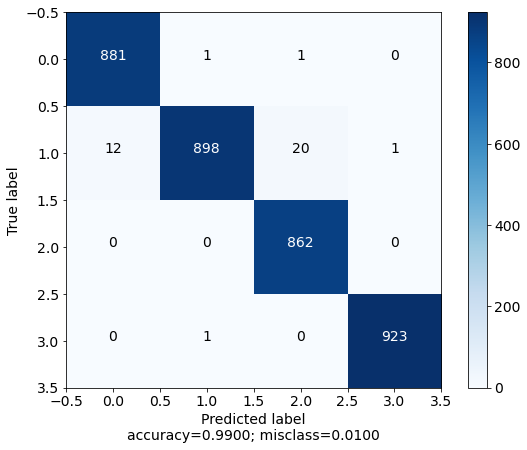

In [6]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from utils import plot_confusion_matrix

y_true = []
y_pred = []

cnn.eval()
with torch.no_grad():
    for batch, labels in tqdm(val_dl):

        torch.cuda.empty_cache()
        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)
        y_true.append(labels.to("cpu"))
        y_pred.append(torch.argmax(cnn(batch), 1).to("cpu"))

# why is this so annoying
y_true2 = torch.Tensor().to("cpu")
y_pred2 = torch.Tensor().to("cpu")
for t1, t2 in zip(y_true, y_pred):
    y_true2 = torch.cat((y_true2, t1), dim=0)
    y_pred2 = torch.cat((y_pred2, t2), dim=0)

conf_m = confusion_matrix(y_true2, y_pred2)

plot_confusion_matrix(conf_m)

## RNN


Even though the CNN worked pretty well, I wanted to use a second approach. I decided to implement a RNN to see if it works because I wanted to use an LSTM for the step prediction part.

In [4]:
from Data import get_SlidingWindow_Dataloader, get_balanced_dataset, load_dataframes
import utils
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df = get_balanced_dataset(data_path=DATA_PATH, label_path= LABEL_PATH, method="expand", labels="activity") # cut expand SMOTE interpolate
#df = load_dataframes(labels="start")

train_dl, val_dl, fitted_scaler = get_SlidingWindow_Dataloader(df=df,
                                                                scaler = scaler,
                                                                ordered_df=True,
                                                                window_size=100,
                                                                step_size=1,
                                                                train_test_split=0.9,
                                                                batch_size=64,
                                                                shape_for="lstm",
                                                                target_index="first")

DEVICE = utils.get_device(cuda=True)

expand class of 148312 samples by factor 3
expand class of 62529 samples by factor 7
expand class of 50751 samples by factor 9
Using cpu for training


In [5]:
from LSTM import RNN

num_layers = 5

rnn = RNN(input_size=6, hidden_size=128, num_layers=num_layers, activity=True, n_classes=4, output_element="first")

In [7]:
import torch
rnn.load_state_dict(torch.load(RNN_PATH))

<All keys matched successfully>

Sadly, all output-cells got cleared when I up and downloaded this notebook to google colab (local for debugging, online for training).
The RNN trained much faster than the CNN but only reached around ~75% accuracy.

In [8]:
from training import train_model
from torch import nn
from sklearn.metrics import accuracy_score
DEVICE = utils.get_device(cuda=True)

criterion = nn.CrossEntropyLoss()

EPOCHS = 1
LEARNING_RATE = 0.0001

rnn = rnn.to(DEVICE)
trained_model, t_losses, t_accuracies, v_losses, v_accuracies = train_model(rnn,
                                                                            learning_rate=LEARNING_RATE,
                                                                            criterion=criterion,
                                                                            epochs=EPOCHS,
                                                                            training_dataloader=train_dl,
                                                                            test_dataloader=val_dl,
                                                                            device=DEVICE,
                                                                            patience_epochs=3,
                                                                            path_to_save=RNN_PATH,
                                                                            evaluationfunc=accuracy_score,
                                                                            verbose=True)

Using cpu for training


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

Unfortunately I cannot run the RNN for a single epoch on my system. To reconstruct this output.

In [ ]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from utils import plot_confusion_matrix

y_true = []
y_pred = []

rnn.eval()
with torch.no_grad():
    for batch, labels in tqdm(val_dl):

        torch.cuda.empty_cache()
        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)
        y_true.append(labels.to("cpu"))
        y_pred.append(torch.argmax(rnn(batch), 1).to("cpu"))

# why is this so annoying
y_true2 = torch.Tensor().to("cpu")
y_pred2 = torch.Tensor().to("cpu")
for t1, t2 in zip(y_true, y_pred):
    y_true2 = torch.cat((y_true2, t1), dim=0)
    y_pred2 = torch.cat((y_pred2, t2), dim=0)

conf_m = confusion_matrix(y_true2, y_pred2)

plot_confusion_matrix(conf_m)

# Predict Activities for Testset


Get a scaler fitted on the training data as well as a validation dataloader to evaluate if the loaded model performs right

In [15]:
from sklearn.preprocessing import StandardScaler
from Data import load_dataframes, get_SlidingWindow_Dataloader, get_balanced_dataset

#df = load_dataframes(labels="start")

df = get_balanced_dataset(data_path=DATA_PATH, label_path= LABEL_PATH, method="cut", labels="activity") # cut expand SMOTE interpolate
_, val_dl, fitted_scaler = get_SlidingWindow_Dataloader(df=df,
                                                                scaler = StandardScaler(),
                                                                ordered_df=True,
                                                                window_size=100, # default size is only thing implemented
                                                                step_size=1, # 1
                                                                train_test_split=0.7,
                                                                batch_size=128, # 64 best
                                                                shape_for="cnn",
                                                                target_index="first") # works only with first # doesnt matter

cut class of 460990 samples down to 50751 samples total
cut class of 148312 samples down to 50751 samples total
cut class of 62529 samples down to 50751 samples total
cut class of 50751 samples down to 50751 samples total


In [8]:
from CNN import CNN
import torch
from LSTM import RNN

#model =  RNN(input_size=6, hidden_size=128, num_layers=5, activity=True, n_classes=4, output_element="first")
model = CNN(activity=True)


model.load_state_dict(torch.load(BASE_PATH + "/models/cnn_activity_best.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Evaluate if loaded model is the right (good performing) one.

100%|██████████| 476/476 [00:10<00:00, 44.63it/s]


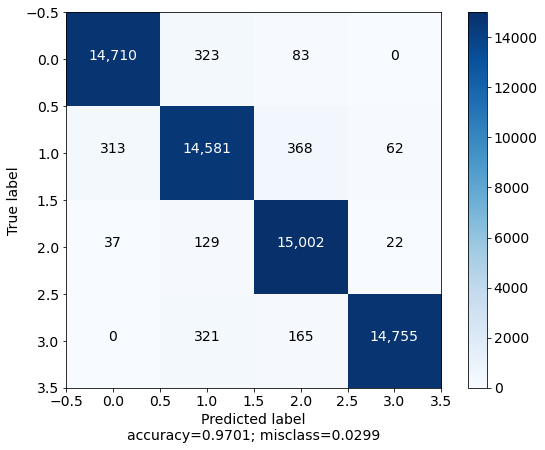

In [16]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from utils import plot_confusion_matrix

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch, labels in tqdm(val_dl):

        torch.cuda.empty_cache()
        batch = batch.to(DEVICE)
        labels = labels.long().to(DEVICE)
        y_true.append(labels.to("cpu"))
        y_pred.append(torch.argmax(model(batch), 1).to("cpu"))

# why is this so annoying
y_true2 = torch.Tensor().to("cpu")
y_pred2 = torch.Tensor().to("cpu")
for t1, t2 in zip(y_true, y_pred):
    y_true2 = torch.cat((y_true2, t1), dim=0)
    y_pred2 = torch.cat((y_pred2, t2), dim=0)

conf_m = confusion_matrix(y_true2, y_pred2)

plot_confusion_matrix(conf_m)

For the predictions I implemented three different methods, one to predict activities and two to predict steps (single and multi output).
The dataloader is adjustable to create sliding window dataloaders for the test data.

In [18]:
import pandas as pd
from Data import get_SlidingWindow_Dataloader
import numpy as np
import torch
from training import predict_activities

WINDOW_SIZE = 100
STEP_SIZE = 1

test_data = pd.read_csv(TEST_PATH)

test_dl, _, _ = get_SlidingWindow_Dataloader(test_data,
                                               scaler=fitted_scaler,
                                                ordered_df=False,
                                                train=False,
                                                 batch_size=1,
                                                 window_size=WINDOW_SIZE,
                                                 step_size=STEP_SIZE,
                                                 train_test_split=None,
                                                  shape_for="cnn",
                                                target_index="first")

result = predict_activities(model, test_dl)


In [24]:

result = pd.Series([int(torch.argmax(item.squeeze()).item()) for item in result]) # get rid of tensor in tensor, get argmax, get value cast to int put in list

In [26]:
result = pd.Series(result)

In [19]:
# double check
result

0         0
1         0
2         0
3         0
4         0
         ..
102086    0
102087    0
102088    0
102089    0
102090    0
Length: 102091, dtype: int64

I planned to do a simple voting with the results for the activities. But because the CNN performed so well and because I didn´t further utilized the results I decided not to.

In [30]:
results = pd.DataFrame()

In [37]:
results = pd.concat([results, result], axis=1)

In [ ]:
result = results.mode(axis=1)

Outputting the improved testset

In [39]:
test_data[" Activity"] = result
test_data.head(10)

In [45]:
test_data.to_csv(BASE_PATH + "output/activities/test_data_with_activities.csv")

As you will see in the next Notebook (Step_Detection) I didn´t used this classified activities any further because I was so occupied with finding a solution to the step predictions. Nevertheless, the steps were not in vain because I was able to reuse much of the logic. I was also able to make sure that the implementations of my models were not to blame for the poor results of the step detection, as they performed extremely well at this point. Especially with the RNN as a precursor to the LSTM, this was important because it was the first sequential model I implemented and otherwise I probably would have looked (for ages) for the error in my implementation or my data generation.